In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import pymc as pm
import scipy as sp
import pickle
from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, robust_scale
import patsy as pt
import arviz as az

In [6]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, nu_prior=None, kernel_type='M52', 
           bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None, 
           model_type='marginal', noise_model='normal', n_ppc=0):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        covs = []
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                covs.append(pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='exponential':
                covs.append(pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m52':
                covs.append(pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m32':
                covs.append(pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m12':
                covs.append(pm.gp.cov.Matern12(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
                
            
        # Covariance model
    
        cov_tot = np.sum(covs)*cov
        
        sigma_n =sigma_prior('sigma_n')

        # Model
        if model_type=='latent': 
            gp = pm.gp.Latent(cov_func=cov_tot)
            f = gp.prior("f", X=X_a)
            if noise_model == 'normal':
                y_ = pm.Normal("y_", mu=f, sigma=sigma_n, observed=y_a)
            elif noise_model == 'TP': 
                nu = nu_prior('nu')
                y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma_n, nu=nu, observed=y_a)
            else:
                raise ValueError('must specify noise for latent model')
                
        elif model_type=='TP':
            nu1 = nu_prior('nu1')
            tp = pm.gp.TP(cov_func=cov_tot, nu=nu1)
            f = tp.prior("f", X=X_a)
            
            if noise_model == 'normal':
                y_ = pm.Normal("y_", mu=f, sigma=sigma_n, observed=y_a)
            elif noise_model == 'TP': 
                nu2 = nu_prior('nu2')
                y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma_n, nu=nu2, observed=y_a)
            else:
                raise ValueError('must specify noise for TP model')            
            
            gp = tp
            
        elif model_type=='marginal':
            # Noise model

            if not (prop_Xu is None):
                # Inducing variables
                num_Xu = int(X_a.shape[0]*prop_Xu)
                Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
                gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
                y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
            else:
                gp = pm.gp.Marginal(cov_func=cov_tot)
                y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        if n_ppc > 0: 
            result = pm.sample_prior_predictive(samples=n_ppc)
        else:
            if not (bayes_kws is None):
                trace = pm.sample(**bayes_kws)
                result = trace
            else:
                start_val = 1
                x0 = dict(zip(['l_'+X_cols[i] for i in range(len(X_cols))], [start_val]*len(X_cols)))
                x0.update({ 'eta': 1, 'sigma_n': 1})

                options={'disp': None, 'maxcor': 10, 
                         'ftol': 2.220446049250313e-12, 'gtol': 1e-12, 
                         'eps': 1e-12, 'maxfun': 15000, 'maxiter': 15000, 
                         'iprint': - 1, 'maxls': 20, 
                         'finite_diff_rel_step': None}
                mp = pm.find_MAP(start = x0, options=options)
                # mp = pm.find_MAP(progressbar=False)

                result = mp
    
    return gp, result, model




def scale_df(df, formula, feature_range=None):
    new_df = []
    df = df.copy(deep=True)
    
    dv = formula.split('~')[0].strip()
    x = df[dv].values.reshape(-1, 1)
    
    median = np.nanmedian(np.log(x))
    iqr = np.nanquantile(np.log(x), q=0.75)-np.nanquantile(np.log(x), q=0.25)
    print(f'dv median, iqr = {median}, {iqr}')

    if dv == 'ts': 
        x = robust_scale(np.log(x))
        dv_range = (x.min(), x.max())
    elif dv == 'vamp2_eq':
        x = robust_scale(x)
        dv_range = (x.min(), x.max())
    else: 
        raise ValueError('no dep var recognized')
    new_df.append(pd.Series(x.flatten(), name=dv))
    
    print(f'dv range is {dv_range}') 

    
    if feature_range is None: 
        feature_range = dv_range
    
    df.drop(labels=dv, axis=1, inplace=True)
    
    for col in df.columns: 
        x = df[col].values.reshape(-1, 1)
        if col == 'hp_ix': 
            pass
        elif col in ['dim', 'lag', 'steep', 'cent', 'states']: 
            x = minmax_scale(x, feature_range=feature_range)
        else: 
            pass
        new_df.append(pd.Series(x.flatten(), name=col))
            
    new_df = pd.concat(new_df, axis=1)
    return new_df
    
    

In [7]:
def get_formula(dv, trans, feat): 
    formula = f"{dv} ~  dim + lag + states"
    if feat == 'distances': 
        formula += ' + scheme'
        if (trans == 'logistic'): 
            formula += " + steep + cent"
    print(formula)
    return formula


def get_dataframes(data_s, feat, trans, formula): 
    X = data_s.query(f"(feat == '{feat}')")
    if trans is not None: 
        X = X.query(f"trans == '{trans}'")
    ydf, Xdf = pt.dmatrices(formula, data=X, return_type='dataframe', NA_action='raise')
    Xdf.drop(labels=['Intercept'], axis=1, inplace=True)
    return ydf, Xdf

def subset_data(ydf, Xdf, hp_ix=None):
    if hp_ix is not None: 
        ix = data.hp_ix < hp_ix
        ydf = ydf.loc[ix, :]
        Xdf = Xdf.loc[ix, :] 
        
    return ydf, Xdf

In [8]:
protein = '1fme'
lag=41
proc=2

# pre-processing params
data_cols = ['median', 'tica__dim', 'tica__lag', 'cluster__k', 'feature__value', 'distances__scheme', 'distances__transform', 
             'distances__steepness', 'distances__centre'
]
var_names_short = ['ts', 'dim', 'lag', 'states', 'feat', 'scheme', 'trans', 'steep', 'cent']
name_dict = dict(zip(data_cols, var_names_short))
scaling = dict(dim=[1, 20], lag=[1, 100],states=[10, 500], steep=[0, 50], cent=[0, 1.5])

# Bayesian kws
bayes_kws = dict(draws=1000, tune=1000, chains=4, cores=4, target_accept=0.90)

# Load data
summary_paths = [f'../{protein}/summary_batch1.h5',  f'../{protein}/summary_batch2.h5']



hp_paths = ['../../experiments/hpsample.h5', '../../experiments/new_hpsample.h5']
hps = []
for hp_path in hp_paths:
    hp = pd.read_hdf(hp_path)
    hp.reset_index(inplace=True)
    hps.append(hp)
hps = pd.concat(hps)

tmp = []
for summary_path in summary_paths:
    tmp.append(pd.read_hdf(summary_path, key='timescales'))
timescales = pd.concat(tmp)

# vamps = pd.read_hdf(summary_path, key='vamps')
timescales.reset_index(inplace=True)
# vamps.reset_index(inplace=True)

# Create main data DF
data = timescales.query(f"process=={proc}").query(f'lag=={lag}')
data = data.merge(hps, on=['hp_ix'], how='left')
data = data.loc[:, data_cols+['hp_ix']]
data.rename(mapper=name_dict, axis=1, inplace=True)

# Add GMRQ from timescale: 
data['vamp2_eq'] = 1+np.exp(-lag/data['ts'])**2


In [9]:

params = [['dihedrals', None], ['distances', 'linear'], ['distances', 'logistic']]
kernels = ['exponential', 'rbf', 'm32', 'm52']
dv = 'ts'

l_prior = gamma(1, 0.5)
eta_prior = hcauchy(1)
sigma_prior = hcauchy(1)

out_dir = Path(f'../{protein}').joinpath('sensitivity', dv)
out_dir.mkdir(parents=True, exist_ok=True)

for kernel in kernels: 
    print(kernel)
    for feat, trans in params:
        print(feat, trans)
        
        out_path = out_dir.joinpath(f"{feat}_{trans}_{kernel}.pkl")

        formula = get_formula(dv, trans, feat)
        data_s = scale_df(data, formula)
        ydf, Xdf = get_dataframes(data_s, feat, trans, formula)
        ydf, Xdf = subset_data(ydf, Xdf, hp_ix=329)

        gp, mp, model = fit_gp(y=ydf, X=Xdf,  
                                l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,
                                kernel_type=kernel, 
                                prop_Xu=None,  
                                bayes_kws=None, model_type='marginal', 
                                noise_model=None, nu_prior=None, 
                                n_ppc=0)  
        with model: 
            y_pred, var = gp.predict(Xdf.values,point=mp, diag=True)

        rmse = np.sqrt(np.sum((ydf.values.flatten()-y_pred)**2))

        results = {'trace': mp, 'data_s': pd.concat([ydf,Xdf], axis=1), 
                   'formula': formula, 'lag': lag, 'proc': proc}

        pickle.dump(obj=results, file=out_path.open('wb'))

        with sns.plotting_context('paper'):
            plt.scatter(ydf.values, y_pred)
            plt.title(f"rmse: {rmse:4.2f}")
            lim = np.max([np.abs(np.min(ydf.values)), np.max(ydf.values)])*1.1
            plt.ylim(-lim, lim)
            plt.xlim(-lim, lim)
            plt.plot([-lim, lim], [-lim, lim])
            plt.xlabel('observed values')
            plt.ylabel('predicted values')

            plt.savefig(out_path.with_suffix('.pdf'), bbox_inches='tight')
            plt.close()

exponential
dihedrals None
ts ~  dim + lag + states
dv median, iqr = 7.608876608833085, 0.6489738308067583
dv range is (-2.5680505392801685, 3.82388738749289)



distances linear
ts ~  dim + lag + states + scheme
dv median, iqr = 7.608876608833085, 0.6489738308067583
dv range is (-2.5680505392801685, 3.82388738749289)


KeyboardInterrupt: 

## Scratch

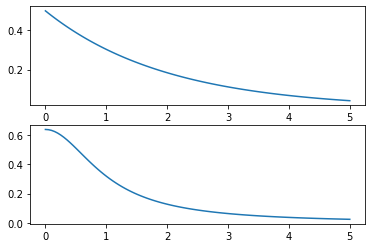

In [17]:
x = np.linspace(0, 5, 100)
fig, ax = plt.subplots(2)

pdf1 = pm.Gamma.dist(1, 0.5)
ax[0].plot(x, np.exp(pm.logp(pdf1, x).eval()))
pdf2 = pm.HalfCauchy.dist(1)
ax[1].plot(x, np.exp(pm.logp(pdf2, x).eval()))
# ax[0].set_ylim(0, .1)
# ax[1].set_ylim(0, .1)

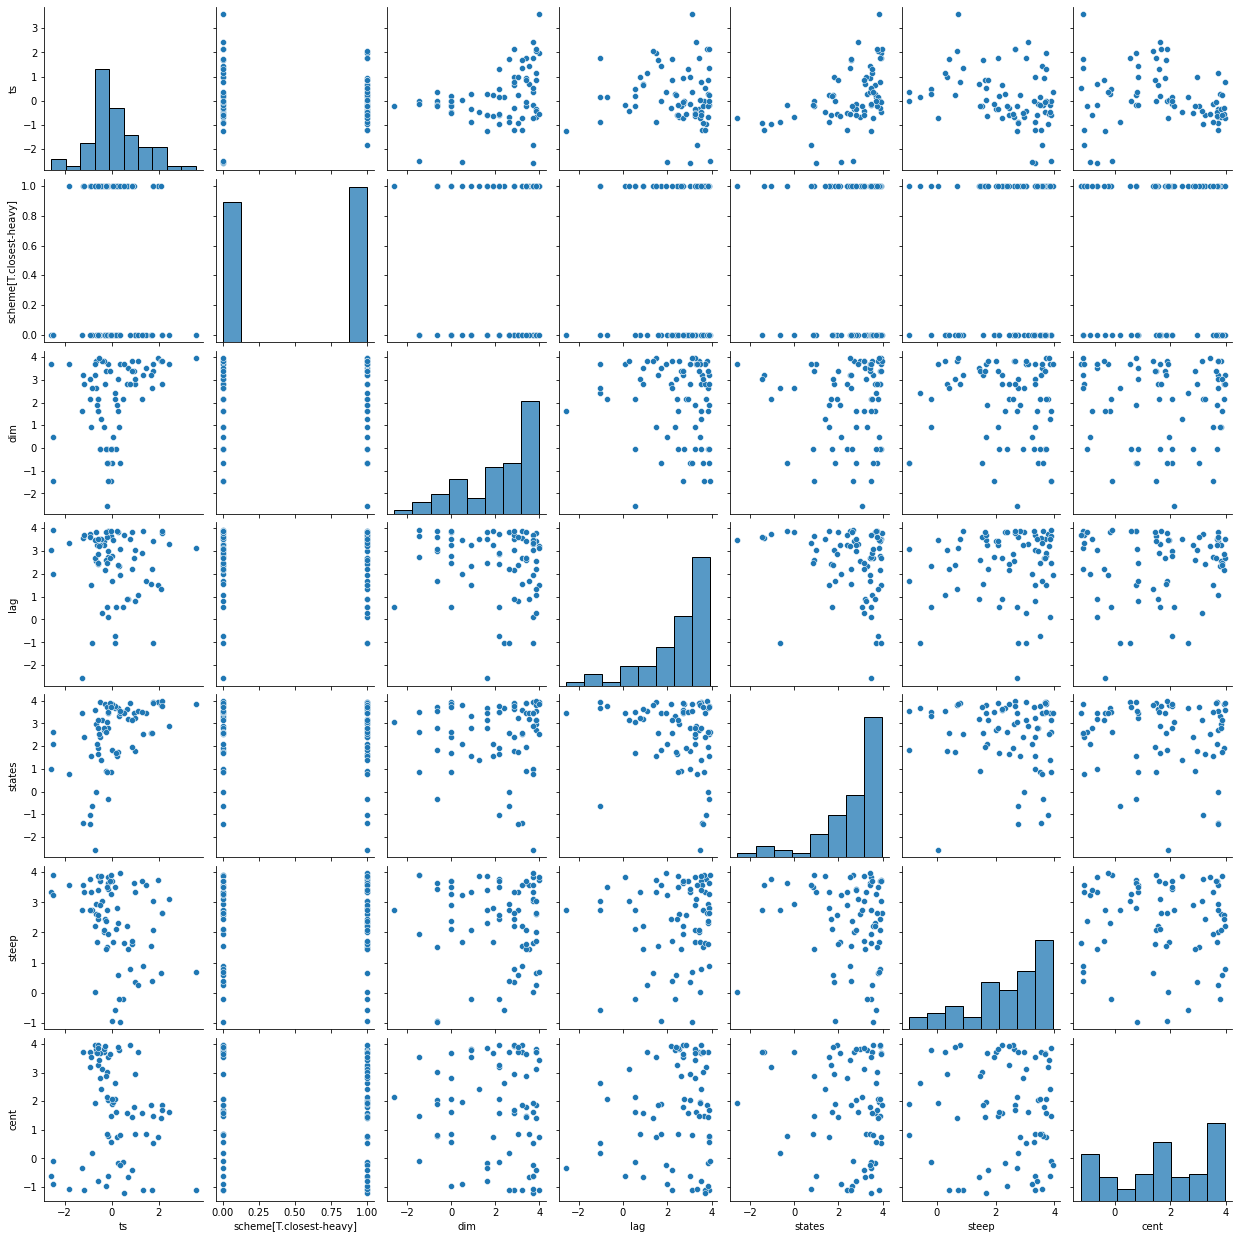

In [97]:
sns.pairplot(pd.concat([ydf,Xdf], axis=1))

ts ~  dim + lag + states + scheme + steep + cent
dv is ts
dv range is (-2.5680505392801685, 3.965207192114922)



1.01, 0.96, 0.99, 0.97, 0.97


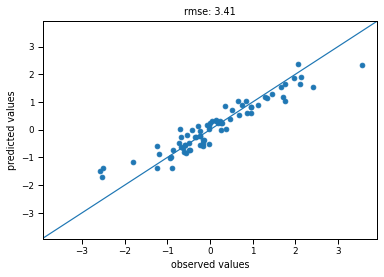

In [18]:
l_prior = gamma(1, 0.5)
eta_prior = hcauchy(1)
sigma_prior = hcauchy(1)
nu_prior = hcauchy(1)

kernel='exponential'
trans = 'logistic'
feat = 'distances'
dv = 'ts'

formula = get_formula(dv, trans, feat)
data_s = scale_df(data, formula)
ydf, Xdf = get_dataframes(data_s, feat, trans, formula)
ydf, Xdf = subset_data(ydf, Xdf, hp_ix=329)

bayes_kws = None #dict(draws=1000, tune=1000, chains=2, cores=2, target_accept=0.9)


gp, mp, model = fit_gp(y=ydf, X=Xdf,  
                        l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,
                        kernel_type=kernel, 
                        prop_Xu=None,  
                        bayes_kws=bayes_kws, model_type='marginal', 
                        noise_model=None, nu_prior=None, 
                        n_ppc=0)  



# Prediction
with model: 
    y_pred, var = gp.predict(Xdf.values,point=mp, diag=True)

    rmse = np.sqrt(np.sum((ydf.values.flatten()-y_pred)**2))

# Plot result
with sns.plotting_context('paper'):
    plt.scatter(ydf.values, y_pred)
    plt.title(f"rmse: {rmse:4.2f}")
    lim = np.max([np.abs(np.min(ydf.values)), np.max(ydf.values)])*1.1
    plt.ylim(-lim, lim)
    plt.xlim(-lim, lim)
    # plt.ylim(-9, 9)
    # plt.xlim(-9, 9)
    plt.plot([-lim, lim], [-lim, lim])
    plt.xlabel('observed values')
    plt.ylabel('predicted values')
print(f"{1/mp['l_cent']:4.2f}, {1/mp['l_steep']:4.2f}, {1/mp['l_dim']:4.2f}, {1/mp['l_lag']:4.2f}, {1/mp['l_states']:4.2f}")

In [122]:
with model: 
    ppc = pm.sample_posterior_predictive(mp)

<AxesSubplot:xlabel='y_ / y_'>

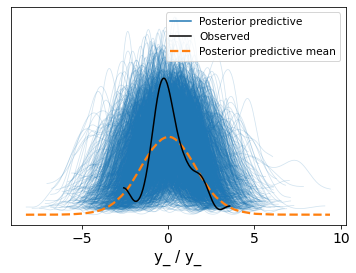

In [123]:
pm.plot_ppc(ppc)
# plt.xlim(-8, 2)

In [55]:
# pm.summary(trace)

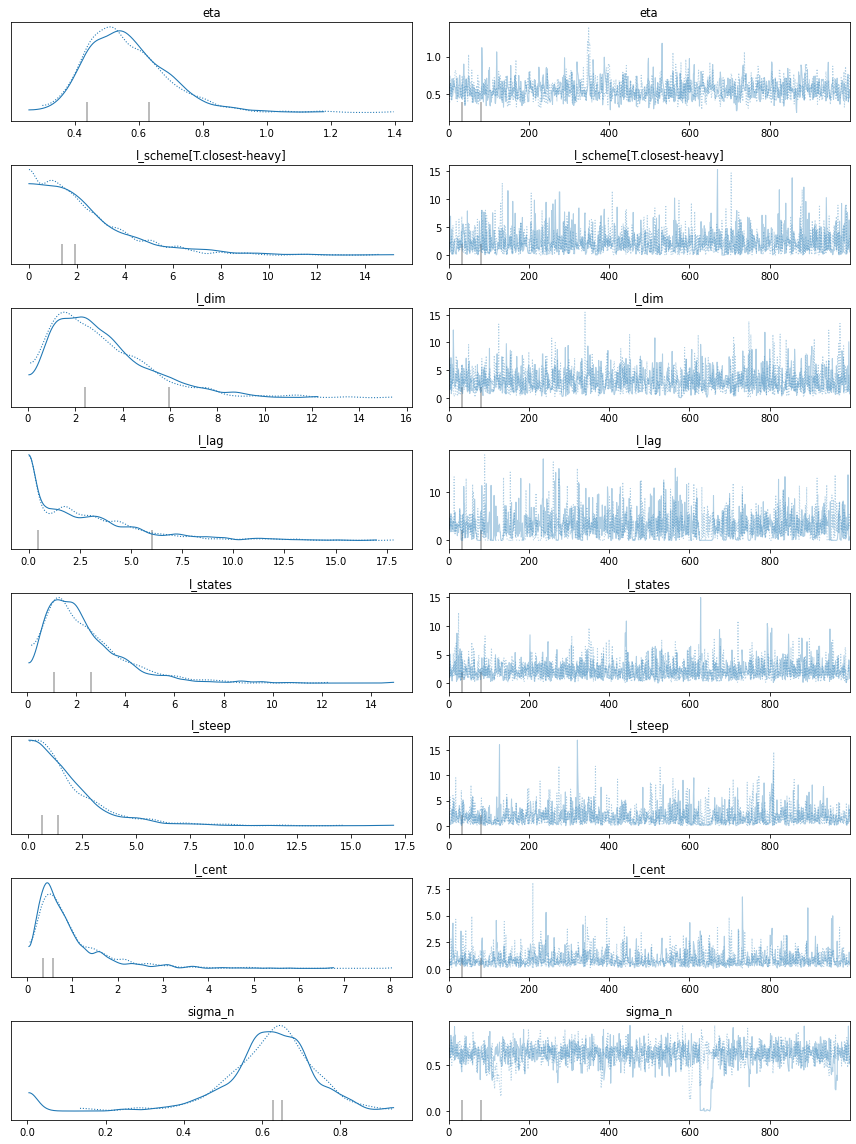

In [124]:
_ = pm.plot_trace(mp)
plt.tight_layout()

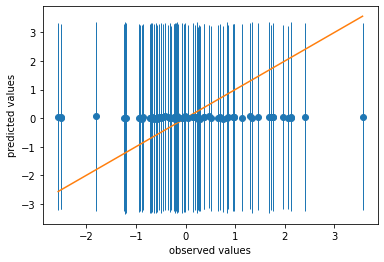

In [125]:
y_ppc = np.array(ppc['posterior_predictive'].y_)
y_obs = np.array(ydf.values)

y_mean = np.mean(y_ppc, axis=(0,1))
y_std = np.sqrt(np.var(y_ppc, axis=(0,1)))
plt.errorbar(y_obs, y_mean, yerr=2*y_std, lw=0, elinewidth=1, marker='o')
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()])
plt.ylabel('predicted values')
_ = plt.xlabel('observed values')
# plt.ylim(-8, 2)
# plt.xlim(-8, 2)

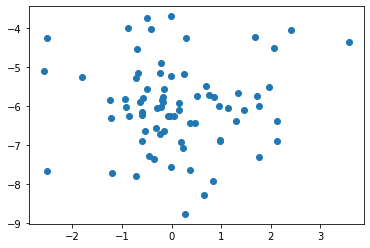

In [116]:
plt.scatter(y_obs, y_ppc[0, 0, :])

In [65]:
# _ = plt.hist(np.array(ppc.prior_predictive['y_']).flatten(), bins=1000)

# plt.ylim(0, 100)
    
# print(np.mean(np.abs(np.array(ppc.prior_predictive['y_']).flatten())>10))
# # plt.xlim(-10, 10)


0.50, 0.50, 0.50, 0.50, 0.49


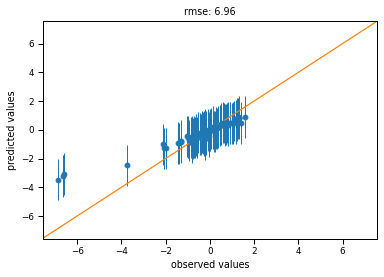

In [125]:
gp, mp, model = fit_gp(y=ydf, X=Xdf,  
                        l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,
                        kernel_type=kernel, 
                        prop_Xu=None,  
                        bayes_kws=None, model_type='marginal', 
                        noise_model=None, nu_prior=None, 
                        n_ppc=0)  



# Prediction
with model: 
    y_pred, var = gp.predict(Xdf.values,point=mp, diag=True)

    rmse = np.sqrt(np.sum((ydf.values.flatten()-y_pred)**2))

# Plot result
with sns.plotting_context('paper'):
    plt.errorbar(ydf.values, y_pred, yerr=np.sqrt(var)*2, lw=0, elinewidth=1, marker='o')
    plt.title(f"rmse: {rmse:4.2f}")
    lim = np.max([np.abs(np.min(ydf.values)), np.max(ydf.values)])*1.1
    plt.ylim(-lim, lim)
    plt.xlim(-lim, lim)
    # plt.ylim(-9, 9)
    # plt.xlim(-9, 9)
    plt.plot([-lim, lim], [-lim, lim])
    plt.xlabel('observed values')
    plt.ylabel('predicted values')
print(f"{1/mp['l_cent']:4.2f}, {1/mp['l_steep']:4.2f}, {1/mp['l_dim']:4.2f}, {1/mp['l_lag']:4.2f}, {1/mp['l_states']:4.2f}")